In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Activation, MaxPool2D, SeparableConv2D, AveragePooling2D, concatenate
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.utils import plot_model, to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime
%matplotlib inline

In [2]:
import FourierOpticsLib as FO
import MieLibrary as mie

In [3]:
ds_path = "/scr/sci/mhayman/holodec/holodec-ml-data/"
#ds_name = "synthetic_holograms_v02_ft_ac_d_amplitude_float32.nc"
#ds_name = "synthetic_holograms_v02_ft_ac_d_real_imag_float32.nc"
#ds_name = "synthetic_holograms_v02_ft_ac_d_real_imag_float32_histogram.nc"
#ds_name = "synthetic_holograms_v02_ft_ac_z_real_imag_float32_histogram.nc"
# ds_name = "synthetic_holograms_v02_ft_ac_z_real_imag_amplitude_float32_histogram.nc" # 3 point histogram
#ds_name = "synthethic_holograms_v0_ft_ac_d_amplitude_float32_histogram.nc"  # single particle histograms
#ds_name = "synthethic_holograms_v0_ft_ac_dzxy_amplitude_real_imag_float32_histogram.nc"  # single particle

ds_name = "synthethic_holograms_v0_svd_ac_amplitude_float.nc"

num_epochs = 30



ds = xr.open_dataset(ds_path+ds_name)  # file with mean (DC) value removed

In [4]:
pixwid = 3e-6  # size of pixels
wavelength = 355e-9  # laser wavelength

In [5]:
split_index = 7000  # number of training+validation points
valid_index = 2000  # number of validation points
all_labels = ds[["d"]].to_dataframe()
train_labels = all_labels.iloc[valid_index:split_index]
test_labels = all_labels.iloc[split_index:]
val_labels = all_labels.iloc[:valid_index]
scaler = MinMaxScaler()
scaled_train_labels = pd.DataFrame(scaler.fit_transform(train_labels), index=train_labels.index, columns=train_labels.columns)
scaled_val_labels = pd.DataFrame(scaler.fit_transform(val_labels), index=val_labels.index, columns=val_labels.columns)
scaled_test_labels = pd.DataFrame(scaler.transform(test_labels), index=test_labels.index, columns=test_labels.columns)

In [7]:
ds['image_svd'].dims

('channels', 'filter_number', 'hologram_number')

In [8]:
in_data = ds['image_svd'].transpose('hologram_number','filter_number','channels')

In [ ]:
# if not "channel" in ds["image_ft"].dims:
#     in_data = ds["image_ft"].transpose("hologram_number", "xsize", 'ysize').expand_dims("channel", 3)
# else:
#     in_data = ds["image_ft"].transpose("hologram_number", "xsize", 'ysize',"channel")

In [ ]:
ds["image"].coords['xsize']

In [ ]:
in_data0.coords['xsize'].size
image_grid = FO.Coordinate_Grid(((in_data0.coords['xsize'].size,in_data0.coords['ysize'].size),(pixwid,pixwid)),inputType='ccd')

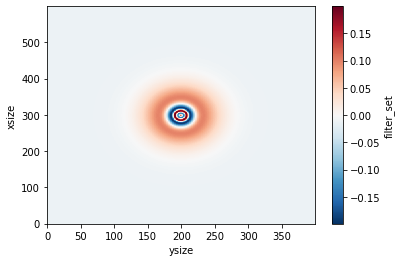

In [9]:
# check that the svd filters were created correctly
ds['filter_set'].isel(filter_number=4).plot()

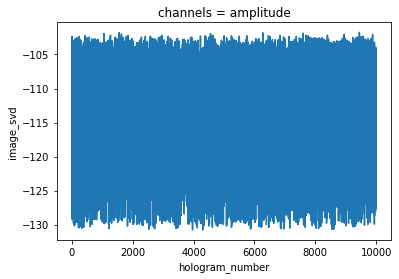

In [16]:
in_data.sel(filter_number=0).plot()

In [ ]:
# # Perform PCA to prefilter input data
# max_angle = np.sqrt(np.max(image_grid.fx**2+image_grid.fy**2))*wavelength
# ang_grid = np.linspace(0,max_angle,500)

# particle_range = np.linspace(5,100,100)*1e-6

# scat_data = np.zeros((ang_grid.size,particle_range.size))
# for ir,r in enumerate(particle_range):
#     scat_data[:,ir] = np.abs(mie.Mie_PhaseMatrix(1.3,2*np.pi*r/wavelength,ang_grid)[0,:])
#     scat_data[:,ir] = scat_data[:,ir]/np.sum(scat_data[:,ir])  # normalize the area under the curve

In [ ]:
# max_angle

In [ ]:
# plt.figure()
# plt.plot(ang_grid,scat_data)
# plt.xlabel('scattering angle [radians]')
# plt.ylabel('amplitude')
# plt.grid(b=True)

In [ ]:
# pca_data = scat_data.copy()
# pca_mean = np.mean(pca_data,axis=0,keepdims=True)
# pca_data = pca_data-pca_mean

# u,s,v = np.linalg.svd(pca_data.T)

In [ ]:
# plt.figure()
# plt.plot(s)
# plt.yscale('log')
# plt.xlabel('Principle Component')
# plt.ylabel('Magnitude')
# plt.grid(b=True)

In [ ]:
# # based on the above plot, decide where to truncate the PCA basis set
# itrunc = 20
# vtrunc = v[:itrunc,:]
# utrunc = u[:,:itrunc]

In [ ]:
# plt.figure()
# plt.plot(ang_grid,vtrunc.T)
# plt.xlabel('scattering angle [radians]')
# plt.grid(b=True)

# plt.figure()
# plt.plot(particle_range*1e6,utrunc)
# plt.xlabel('particle radius [$\mu m$]')
# plt.grid(b=True)

In [ ]:
# plt.figure()
# plt.plot(filter_set[:,:,5].values.flatten(),'.',markersize=1)

# plt.figure()
# plt.plot(ang_grid,vtrunc[5,:])
# plt.plot(grid_set.flatten(),filter_set.values[:,:,5].flatten(),'.')

# plt.figure()
# plt.imshow(filter_set[:,:,5])
# plt.colorbar()

In [ ]:
# in_data = xr.DataArray(np.zeros((in_data0.coords['hologram_number'].size,itrunc,
#                                  in_data0.coords['channel'].size)),
#                       dims=('hologram_number','filter_number','channel'))


# # in_data = (in_data0*filter_set).sum(dim=('xsize','ysize',))
# for ai in in_data0.coords['hologram_number'].values:
#     for bi,ch in enumerate(in_data0.coords['channel'].values):
#         in_data.values[ai,:,bi] = ((in_data0.isel(hologram_number=ai,channel=bi)*filter_set).sum(dim=('xsize','ysize',))).values

In [ ]:
# (in_data0.isel(hologram_number=60,channel=0)*filter_set).sum(dim=('xsize','ysize',))

In [ ]:
# in_data.sizes['hologram_number']

In [ ]:
# in_data.dims

In [ ]:
# in_data.coords['channel'].size

In [ ]:
# ds["image_ft"].max()

In [ ]:
# plt.figure(); plt.plot(scaled_train_labels.values[10,:])

In [17]:
scaled_in_data = in_data / 200

In [21]:
nn_descript = 'DenseNN_SVD_RMSProp'

filter_input = Input(shape=scaled_in_data.shape[1:])
flat = Flatten()(filter_input)
dense_1_ch1 = Dense(64, activation="relu")(flat)
dense_2_ch1 = Dense(32, activation="relu")(dense_1_ch1)
dense_3_ch1 = Dense(16, activation="relu")(dense_2_ch1)
out = Dense(all_labels.shape[1],activation='relu')(dense_3_ch1)  # number of outputs determined by the parameters we are training to
mod = Model(filter_input, out)
mod.compile(optimizer="adam", loss="mse",metrics=['acc'])
mod.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                1344      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________

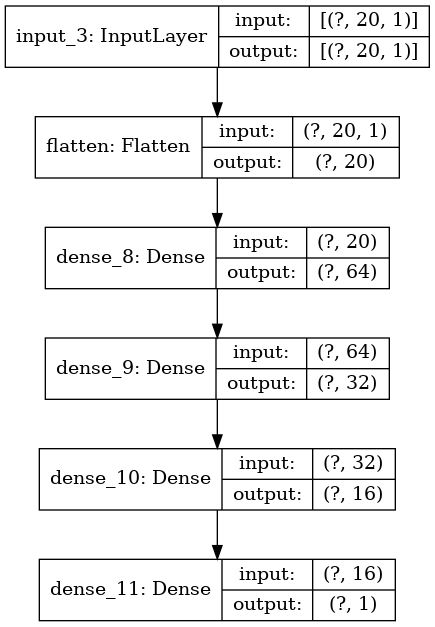

In [22]:
plot_model(mod,show_shapes=True,to_file="results/holodec_"+nn_descript+'_'+ds_name.replace(".nc","")+".png")

In [23]:
history = mod.fit(scaled_in_data[valid_index:split_index].values, scaled_train_labels.values, 
                  batch_size=16, epochs=num_epochs, verbose=1,
                  validation_data=(scaled_in_data[:valid_index].values,scaled_val_labels.values))

Train on 5000 samples, validate on 2000 samples
Epoch 1/30
5000/5000 [==============================] - 3s 539us/sample - loss: 0.0868 - acc: 4.0000e-04 - val_loss: 0.0050 - val_acc: 0.0010
Epoch 2/30
5000/5000 [==============================] - 2s 303us/sample - loss: 0.0040 - acc: 4.0000e-04 - val_loss: 0.0035 - val_acc: 0.0010
Epoch 3/30
5000/5000 [==============================] - 2s 303us/sample - loss: 0.0030 - acc: 4.0000e-04 - val_loss: 0.0027 - val_acc: 0.0010
Epoch 4/30
5000/5000 [==============================] - 2s 357us/sample - loss: 0.0024 - acc: 4.0000e-04 - val_loss: 0.0026 - val_acc: 0.0010
Epoch 5/30
5000/5000 [==============================] - 2s 309us/sample - loss: 0.0022 - acc: 4.0000e-04 - val_loss: 0.0022 - val_acc: 0.0010
Epoch 6/30
5000/5000 [==============================] - 2s 345us/sample - loss: 0.0021 - acc: 4.0000e-04 - val_loss: 0.0020 - val_acc: 0.0010
Epoch 7/30
5000/5000 [==============================] - 2s 324us/sample - loss: 0.0018 - acc: 4.0000

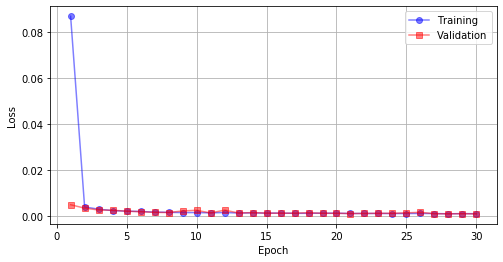

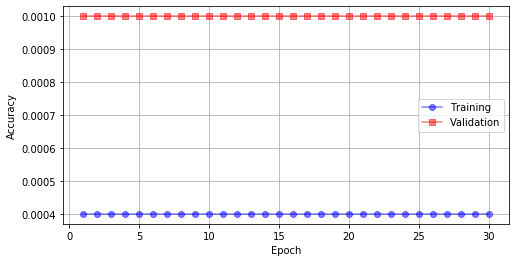

In [24]:
epochs = np.arange(len(history.history['acc']))+1
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(epochs,history.history['loss'],'bo-',alpha=0.5,label='Training')
ax.plot(epochs,history.history['val_loss'],'rs-',alpha=0.5,label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(b=True)
plt.legend()
plt.savefig("results/LossHistory_"+nn_descript+'_'+ds_name.replace(".nc","")+f"_{num_epochs}epochs"+".png", dpi=200, bbox_inches="tight")

fig, bx = plt.subplots(1, 1, figsize=(8, 4))
bx.plot(epochs,history.history['acc'],'bo-',alpha=0.5,label='Training')
bx.plot(epochs,history.history['val_acc'],'rs-',alpha=0.5,label='Validation')
bx.set_xlabel('Epoch')
bx.set_ylabel('Accuracy')
bx.grid(b=True)
plt.legend()
plt.savefig("results/AccuracyHistory_"+nn_descript+'_'+ds_name.replace(".nc","")+f"_{num_epochs}epochs"+".png", dpi=200, bbox_inches="tight")


In [ ]:
# can skip the training process and just load the CNN model
#mod = load_model("holodec_ft_cnn.h5")

In [25]:
cnn_start = datetime.datetime.now()
preds_out = mod.predict(scaled_in_data.values, batch_size=64)
cnn_stop = datetime.datetime.now()
print(f"{scaled_in_data.values.shape[0]} samples in {(cnn_stop-cnn_start).total_seconds()} seconds")
print(f"for {(cnn_stop-cnn_start).total_seconds()/scaled_in_data.values.shape[0]} seconds per hologram")

10000 samples in 0.381147 seconds
for 3.81147e-05 seconds per hologram


In [26]:
save_model(mod, ds_path+"/models/holodec_histogram_"+nn_descript+'_'+ds_name.replace(".nc","")+f"{num_epochs}epochs"+".h5", save_format="h5")

In [27]:
preds_out.shape

(10000, 1)

In [29]:
preds_original = scaler.inverse_transform(preds_out)

In [30]:
mean_error = np.mean(preds_original[split_index:] - test_labels.values, axis=0)
std_error = np.std(preds_original[split_index:] - test_labels.values, axis=0)

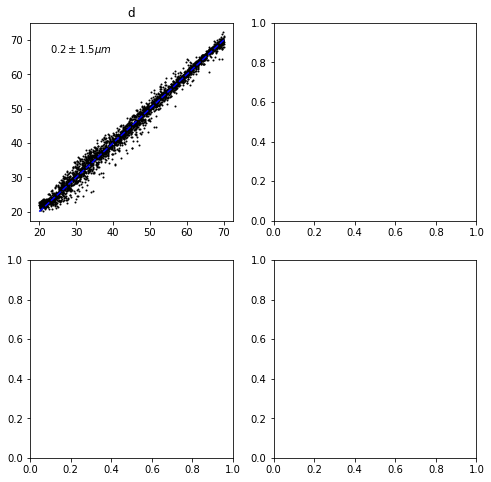

In [33]:
validation_data = {}
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for a, clabel in enumerate(all_labels.columns):
    ax=axes.ravel()[a]
    ax.scatter(test_labels.iloc[:, a], preds_original[split_index:, a], 1, 'k')
    diag = np.linspace(test_labels.iloc[:, a].min(), test_labels.iloc[:, a].max(), 10)
    ax.plot(diag, diag, 'b--' )
    ax.set_title(test_labels.columns[a])
    plt.text(0.1,0.9,f"${mean_error[a]:.1f} \pm {std_error[a]:.1f} \mu m$",ha='left',va='top',transform=ax.transAxes)
    validation_data[test_labels.columns[a]] = test_labels.iloc[:, a]
    validation_data[test_labels.columns[a]+'_pred'] = preds_original[split_index:, a]
plt.savefig("results/error_scatter_"+nn_descript+'_'+ds_name.replace(".nc","")+f"_{num_epochs}epochs"+".png", dpi=200, bbox_inches="tight")
#plt.savefig("results/error_scatter_denseNN_"+ds_file.replace(".nc","_")+"".join(all_labels.columns)+".png", dpi=200, bbox_inches="tight")
validation_data_df = pd.DataFrame(validation_data)
validation_data_df.to_csv('results/validation_data_denseNN_'+nn_descript+'_'+ds_name.replace(".nc","")+f"_{num_epochs}epochs"+''.join(all_labels.columns)+'.txt')
    

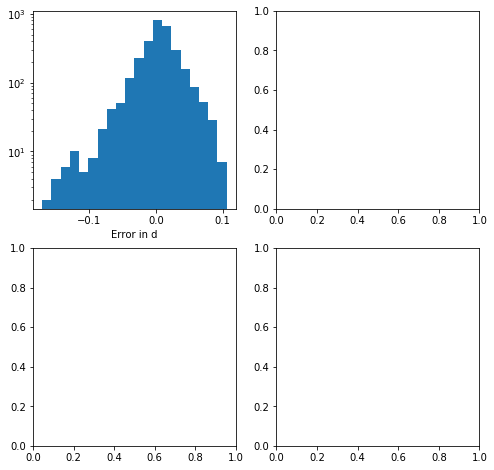

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for a, clabel in enumerate(all_labels.columns):
    ax=axes.ravel()[a]
    ax.hist( (preds_original[split_index:, a] - test_labels.iloc[:, a].values) / (test_labels.iloc[:, a].max() - test_labels.iloc[:, a].min()),
           bins=20)
    ax.set_yscale("log")
    ax.set_xlabel("Error in "+test_labels.columns[a])
plt.savefig("results/relative_error_histogram_"+nn_descript+'_'+ds_name.replace(".nc","")+f"_{num_epochs}epochs"+".png", dpi=200, bbox_inches="tight")

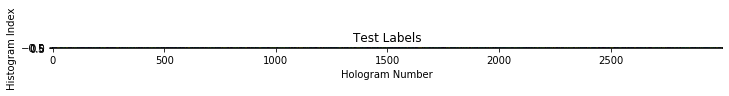

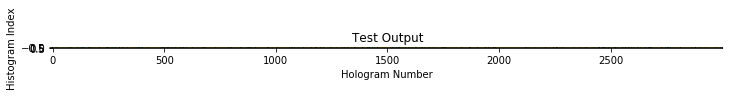

In [28]:
fig,axes = plt.subplots(1,1,figsize=(12,4))
axes.imshow(scaled_test_labels.values.T)
axes.set_xlabel('Hologram Number')
axes.set_ylabel('Histogram Index')
axes.set_title('Test Labels')
plt.savefig("results/Label_Histogram_"+nn_descript+'_'+ds_name.replace(".nc","")+f"_{num_epochs}epochs"+".png", dpi=200, bbox_inches="tight")

fig,axes = plt.subplots(1,1,figsize=(12,4))
axes.imshow(preds_out[split_index:,:].T,vmin=0,vmax=0.3)
axes.set_xlabel('Hologram Number')
axes.set_ylabel('Histogram Index')
axes.set_title('Test Output')
plt.savefig("results/Output_Histogram_"+nn_descript+'_'+ds_name.replace(".nc","")+f"_{num_epochs}epochs"+".png", dpi=200, bbox_inches="tight")


In [ ]:
hindices = [10,234,500,1293]
fig,axes = plt.subplots(2,2,figsize=(8,8))
axes=axes.ravel()
for hi,holo_index in enumerate(hindices):
    axes[hi].plot(ds['particle_histogram'].z_bin_centers.values,scaled_test_labels.iloc[holo_index,:],label=f'Test Label {holo_index}')
    axes[hi].plot(ds['particle_histogram'].z_bin_centers.values,preds_out[split_index+holo_index,0:],label=f'Test Output {holo_index}')
    axes[hi].set_xlabel('Particle Diameter [$\mu m$]')
    
    #axes[hi].plot(test_labels.iloc[holo_index,:],label=f'Test Label {holo_index}')
    #axes[hi].plot(preds_out[split_index+holo_index,0:],label=f'Test Output {holo_index}')
    
    axes[hi].set_ylabel('Probability')
    
    #axes[hi].set_title(f'Hologram {holo_index}')
    axes[hi].grid(b=True)
    axes[hi].legend()

plt.savefig("results/Example_Hists_"+nn_descript+'_'+ds_name.replace(".nc","")+f"_{num_epochs}epochs"+".png", dpi=200, bbox_inches="tight")

In [ ]:
part_indices = np.nonzero(scaled_test_labels.values)
pred_values = (preds_out[split_index:,:])[part_indices]
label_moments = []
label_moments.append(np.sum(scaled_test_labels.values*ds['particle_histogram'].z_bin_centers.values[np.newaxis,:],axis=1)/np.sum(scaled_test_labels.values,axis=1))
label_moments.append(np.sum(scaled_test_labels.values*ds['particle_histogram'].z_bin_centers.values[np.newaxis,:]**2,axis=1)/np.sum(scaled_test_labels.values,axis=1))
label_moments.append(np.sum(scaled_test_labels.values*ds['particle_histogram'].z_bin_centers.values[np.newaxis,:]**3,axis=1)/np.sum(scaled_test_labels.values,axis=1))
label_moments.append(np.sum(scaled_test_labels.values*ds['particle_histogram'].z_bin_centers.values[np.newaxis,:]**4,axis=1)/np.sum(scaled_test_labels.values,axis=1))

pred_moments = []
pred_moments.append(np.sum(preds_out[split_index:,:]*ds['particle_histogram'].z_bin_centers.values[np.newaxis,:],axis=1)/np.sum(preds_out[split_index:,:],axis=1))
pred_moments.append(np.sum(preds_out[split_index:,:]*ds['particle_histogram'].z_bin_centers.values[np.newaxis,:]**2,axis=1)/np.sum(preds_out[split_index:,:],axis=1))
pred_moments.append(np.sum(preds_out[split_index:,:]*ds['particle_histogram'].z_bin_centers.values[np.newaxis,:]**3,axis=1)/np.sum(preds_out[split_index:,:],axis=1))
pred_moments.append(np.sum(preds_out[split_index:,:]*ds['particle_histogram'].z_bin_centers.values[np.newaxis,:]**4,axis=1)/np.sum(preds_out[split_index:,:],axis=1))
std_pred = np.sqrt(pred_moments[1]-pred_moments[0]**2)

mean_error = []
std_error = []
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for ai,ax in enumerate(axes.ravel()):
    if ai == 0:
        mean_error.append(np.mean(pred_moments[ai]-label_moments[ai]))
    else:
        mean_error.append(np.abs(np.mean(pred_moments[ai]-label_moments[ai]))**(1/(1.0+ai)))
    std_error.append(np.std(pred_moments[ai]-label_moments[ai])**(1/(1.0+ai)))
    ax.scatter(label_moments[ai]**(1/(1.0+ai)),pred_moments[ai]**(1/(1.0+ai)), 1, 'k')
    diag = np.linspace(label_moments[ai].min()**(1/(1.0+ai)), label_moments[ai].max()**(1/(1.0+ai)), 10)
    ax.plot(diag, diag, 'b--' )
    plt.text(0.1,0.9,f"${mean_error[ai]:.1f} \pm {std_error[ai]:.1f} \mu m$",ha='left',va='top',transform=ax.transAxes)
    ax.grid(b=True)
    ax.set_title('moment %d'%(ai+1))
plt.savefig("results/Moment_Scatter_"+nn_descript+'_'+ds_name.replace(".nc","")+f"_{num_epochs}epochs"+".png", dpi=200, bbox_inches="tight")


In [ ]:
np.mean(pred_moments[0]-label_moments[0])

In [ ]:
np.mean((pred_moments[0]-label_moments[0])**2)

In [ ]:
np.mean(pred_moments[1]-pred_moments[0]**2)